# Khmer Sentiment Analysis Using Machine Learning

## Project Overview

This project performs sentiment analysis on Khmer text data using multiple ML models:

- Traditional ML: Logistic Regression, SVM, Naive Bayes
- Deep Learning: LSTM (Bidirectional)

## Key Features:

- Khmer-specific text preprocessing (Unicode normalization, slang handling)
- Balanced dataset handling with class weights
- Comprehensive model comparison and error analysis


## Step 1: Import Required Libraries

We'll import all necessary libraries for:

- **Data manipulation**: pandas, numpy
- **Text processing**: re, unicodedata
- **Visualization**: matplotlib, seaborn
- **Machine Learning**: scikit-learn (traditional ML models)
- **Deep Learning**: TensorFlow/Keras (for LSTM models)

These libraries will help us perform Khmer-specific text preprocessing, feature extraction, and sentiment classification.


In [7]:
import pandas as pd
import re
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import warnings
warnings.filterwarnings('ignore')

# For deep learning models


## Step 2: Load and Explore the Dataset

### Key Task: Build a labeled dataset of Khmer sentiment (positive/negative/neutral)

Loading the preprocessed Khmer sentiment dataset. The dataset contains:

- **text**: Raw Khmer text from social media posts, reviews, or comments
- **target**: Sentiment labels (positive, negative, neutral)

Let's examine the structure and basic statistics of our labeled dataset.


In [8]:
df = pd.read_csv(r'D:\Y5 AMS\Information-WR\IWR Project\Sentiment-Analysis-of-Khmer-Text-Using-ML\notebooks\data\new_final.csv')
df.head()

,text,target
0,វគ្គចុងក្រោយនៃថ្ងៃ http://twitpic.com/67ezh,neutral
1,ទីក្រុងសៀងហៃក៏គួរឱ្យរំភើបផងដែរ (ច្បាស់ណាស់ - អ...,positive
2,វិបត្តិសេដ្ឋកិច្ចជួប Veronique Branquinho នាងត...,negative
3,រីករាយថ្ងៃបុណ្យ!,positive
4,http://twitpic.com/4w75p - ចូលចិត្ត!!,positive


### Dataset Statistics

Check the total number of samples and features in our dataset to understand the scope of our sentiment analysis task.


In [9]:
df.shape

(3870, 2)

### Data Cleaning

Remove any invalid or duplicate entries (e.g., rows where text = 'text'). Reset the index to ensure proper data structure.


In [10]:
### Remove row = 'text'
df = df[df['text'].str.lower() != 'text']
df.reset_index(drop=True, inplace=True)
df.shape

(3870, 2)

### Convert Labels to Numeric

Convert sentiment labels to numeric format:

- **0**: negative
- **1**: neutral
- **2**: positive

This standardized encoding ensures consistency across all models.


In [11]:
# Define label mapping
label_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

# Convert target labels to numeric
df['target'] = df['target'].map(label_map)

# Verify conversion
print("Label distribution after conversion:")
print(df['target'].value_counts().sort_index())
print("\nMapping used: 0=negative, 1=neutral, 2=positive")

Label distribution after conversion:
target
0    1098
1    1570
2    1202
Name: count, dtype: int64

Mapping used: 0=negative, 1=neutral, 2=positive


## Step 3: Khmer-Specific Text Preprocessing

### Key Task: Apply Khmer-specific preprocessing (Unicode normalization, slang handling)

Khmer text presents unique challenges:

1. **Unicode Normalization (NFC)**: Khmer characters can have multiple Unicode representations
2. **Informal Writing & Slang**: Social media contains non-standard Khmer expressions
3. **Mixed Scripts**: Khmer text often includes English words, emojis, and special characters
4. **Special Markers**: URLs, symbols, and formatting characters need to be removed

Our preprocessing pipeline includes:

- Unicode normalization to standardize Khmer characters
- Khmer slang mapping to formal language
- Removal of URLs, emojis, and special symbols
- Preserving Khmer Unicode range (U+1780 to U+17FF)


In [12]:
import re
import unicodedata

# Common Khmer slang/informal mapping (expand this with more slangs)
KHMER_SLANG = {
    "មិនចេះ": "មិនដឹង",
    "ចេះតែ": "តែងតែ",
    "អត់": "មិន",
    "ហ៊ាន": "ហ៊ាន",
    "ស្អប់": "មិនស្រលាញ់",
    "លេង": "លេង",
    "បង": "ខ្ញុំ",
    "ប្អូន": "ខ្ញុំ",
    "គេ": "គាត់",
    "អូន": "ខ្ញុំ",
    "ប៉ុន្មាន": "ប៉ុន្មាន",
    "ហើយ": "រួចហើយ",
    "ទៅណា": "ទៅណា",
    "មែនទេ": "មែនហើយ",
    "ហ្នឹង": "នោះ",
    "ណា": "ណា",
    "អី": "អ្វី",
    "ហេតុអ្វី": "ហេតុអ្វី",
    "អីហ្នឹង": "អ្វីនោះ",
    "ហ្នឹង": "នោះ",
    "ចុះ": "ចុះ",
    "ទៅហើយ": "ទៅរួចហើយ",
    "មែន": "មែន",
    "ហើយ": "រួចហើយ",
    "ណាស់": "ណាស់",
    "សោះ": "សោះ",
    "ទេ": "ទេ",
    "ហ្នឹង": "នោះ",
    "អី": "អ្វី",
    "ហេតុអ្វី": "ហេតុអ្វី", 
    # Add more Khmer slang mappings as you discover them
}


In [13]:

def preprocess_khmer(text):
    # Unicode normalization (NFC for Khmer)
    text = unicodedata.normalize("NFC", text)
    
    # Lowercase (safe for Khmer + English mix)
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)
    
    # Remove special markers like :://, //, etc.
    text = re.sub(r"[:]+\/\/|\/\/", " ", text)
    
    # Handle Khmer slang (replace with standard form)
    for slang, standard in KHMER_SLANG.items():
        text = text.replace(slang, standard)
    
    # Remove emojis & symbols (keep Khmer + numbers + basic punctuation)
    text = re.sub(r"[^\u1780-\u17FF0-9\s\?\!\.]", " ", text)
    
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

### Apply Preprocessing to Dataset

Transform all text data using our Khmer-specific preprocessing function. This creates a cleaned version of the text suitable for feature extraction.


In [14]:
df["text_clean"] = df["text"].apply(preprocess_khmer)

### Analyze Class Distribution

Check the distribution of sentiment labels (positive, negative, neutral). This helps identify class imbalance issues that may affect model performance.


In [15]:
df["target"].value_counts(normalize=True)

target
1    0.405685
2    0.310594
0    0.283721
Name: proportion, dtype: float64

In [16]:
df.head()

,text,target,text_clean
0,វគ្គចុងក្រោយនៃថ្ងៃ http://twitpic.com/67ezh,1,វគ្គចុងក្រោយនៃថ្ងៃ
1,ទីក្រុងសៀងហៃក៏គួរឱ្យរំភើបផងដែរ (ច្បាស់ណាស់ - អ...,2,ទីក្រុងសៀងហៃក៏គួរឱ្យរំភើបផងដែរ ច្បាស់ណាស់ អគារ...
2,វិបត្តិសេដ្ឋកិច្ចជួប Veronique Branquinho នាងត...,0,វិបត្តិសេដ្ឋកិច្ចជួប នាងត្រូវលាឈប់ពីក្រុមហ៊ុន ...
3,រីករាយថ្ងៃបុណ្យ!,2,រីករាយថ្ងៃបុណ្យ!
4,http://twitpic.com/4w75p - ចូលចិត្ត!!,2,ចូលចិត្ត!!


### Handle Class Imbalance

Compute class weights to address imbalanced sentiment distribution. This ensures the model pays appropriate attention to minority classes during training.


In [17]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get unique numeric classes
classes = np.unique(df["target"])
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=df["target"]
)
class_weight = dict(zip(classes, weights))
print("Class weights:", class_weight)

Class weights: {np.int64(0): np.float64(1.174863387978142), np.int64(1): np.float64(0.821656050955414), np.int64(2): np.float64(1.0732113144758735)}


## Step 4: Feature Extraction

### TF-IDF Vectorization

Convert cleaned Khmer text into numerical features using TF-IDF (Term Frequency-Inverse Document Frequency):

- **N-grams**: Using unigrams and bigrams (1,2) to capture word context
- **max_df=0.9**: Ignore terms that appear in more than 90% of documents
- **min_df=5**: Ignore terms that appear in fewer than 5 documents
- **Analyzer='word'**: Word-level tokenization

This vectorization approach helps capture semantic meaning in Khmer text despite the lack of Khmer-specific NLP tools.


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 2),     # unigram + bigram
    max_df=0.9,
    min_df=5
)

In [19]:
tfidf

TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1, 2))

### Train-Test Split

Split the dataset into training (80%) and testing (20%) sets with stratification to maintain class distribution in both sets.


In [20]:
from sklearn.model_selection import train_test_split

X = df["text_clean"]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Step 5: Train Multiple ML Models for Comparison

### Key Task: Train multiple ML models (SVM, Naive Bayes, Logistic Regression)

We'll train and compare three traditional machine learning models:

1. **Logistic Regression**: Linear classifier with regularization
2. **Support Vector Machine (SVM)**: Finds optimal decision boundary
3. **Naive Bayes**: Probabilistic classifier based on Bayes' theorem

Each model will be tuned using RandomizedSearchCV with:

- **Cross-validation**: 3-fold CV for robust evaluation
- **Scoring metric**: F1-macro (balanced performance across all classes)
- **Class weights**: To handle imbalanced data

---

### Model 1: Logistic Regression

Train Logistic Regression with hyperparameter tuning:

- **C**: Regularization strength (0.01 to 10)
- **Solver**: Optimization algorithm (lbfgs, saga)
- **max_iter=2000**: Sufficient iterations for convergence


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

pipe_lr = Pipeline([
    ("tfidf", tfidf),
    ("clf", LogisticRegression(
        class_weight=class_weight,
        random_state=42
    ))
])

param_lr = {
    "clf__penalty": ["l1", "l2", "elasticnet"],
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "clf__solver": ["lbfgs", "liblinear", "saga"],
    "clf__max_iter": [100, 200, 500, 1000, 2000],
    "clf__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0]  # Only used when penalty='elasticnet'
}

rs_lr = RandomizedSearchCV(
    pipe_lr,
    param_lr,
    n_iter=50,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    random_state=42
)
rs_lr.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(max_df=0.9,
                                                              min_df=5,
                                                              ngram_range=(1,
                                                                           2))),
                                             ('clf',
                                              LogisticRegression(class_weight={np.int64(0): np.float64(1.174863387978142),
                                                                               np.int64(1): np.float64(0.821656050955414),
                                                                               np.int64(2): np.float64(1.0732113144758735)},
                                                                 random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100],
                                        'clf__l1_ratio': [0.0, 0.25, 0.5, 0.75,
                                                          1.0],
                                        'clf__max_iter': [100, 200, 500, 1000,
                                                          2000],
                                        'clf__penalty': ['l1', 'l2',
                                                         'elasticnet'],
                                        'clf__solver': ['lbfgs', 'liblinear',
                                                        'saga']},
                   random_state=42, scoring='f1_macro')

In [22]:
# Best parameters
rs_lr.best_params_

{'clf__solver': 'lbfgs',
 'clf__penalty': 'l2',
 'clf__max_iter': 100,
 'clf__l1_ratio': 1.0,
 'clf__C': 100}

In [23]:
# Evaluate on test set
y_pred = rs_lr.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.73      0.71      0.72       220
           1       0.69      0.74      0.71       314
           2       0.79      0.72      0.75       240

    accuracy                           0.73       774
   macro avg       0.73      0.73      0.73       774
weighted avg       0.73      0.73      0.73       774



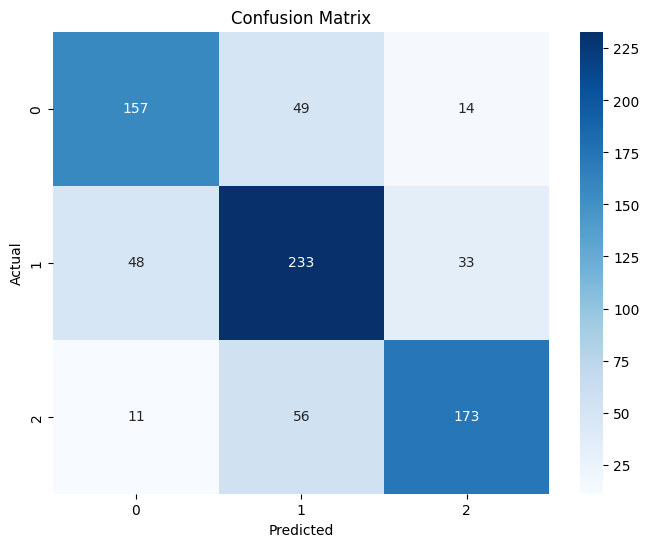

In [24]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Model 2: Support Vector Machine (SVM)

Train LinearSVC with hyperparameter tuning:

- **C**: Regularization parameter (0.01 to 10)
- **class_weight='balanced'**: Handle class imbalance
- LinearSVC is faster than kernel SVM for high-dimensional text data


In [25]:
from sklearn.svm import LinearSVC

pipe_svm = Pipeline([
    ("tfidf", tfidf),
    ("clf", LinearSVC(
        class_weight=class_weight,
        random_state=42
    ))
])

param_svm = {
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l1", "l2"],
    "clf__loss": ["hinge", "squared_hinge"],
    "clf__dual": [True, False],
    "clf__max_iter": [1000, 2000, 3000]
}

rs_svm = RandomizedSearchCV(
    pipe_svm,
    param_svm,
    n_iter=50,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    random_state=42
)
rs_svm.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(max_df=0.9,
                                                              min_df=5,
                                                              ngram_range=(1,
                                                                           2))),
                                             ('clf',
                                              LinearSVC(class_weight={np.int64(0): np.float64(1.174863387978142),
                                                                      np.int64(1): np.float64(0.821656050955414),
                                                                      np.int64(2): np.float64(1.0732113144758735)},
                                                        random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100],
                                        'clf__dual': [True, False],
                                        'clf__loss': ['hinge', 'squared_hinge'],
                                        'clf__max_iter': [1000, 2000, 3000],
                                        'clf__penalty': ['l1', 'l2']},
                   random_state=42, scoring='f1_macro')

In [26]:
#best parameters
rs_svm.best_params_

{'clf__penalty': 'l1',
 'clf__max_iter': 3000,
 'clf__loss': 'squared_hinge',
 'clf__dual': False,
 'clf__C': 10}

In [27]:
# Evaluate on test set
y_pred = rs_svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75       220
           1       0.72      0.80      0.76       314
           2       0.83      0.74      0.78       240

    accuracy                           0.76       774
   macro avg       0.77      0.76      0.76       774
weighted avg       0.77      0.76      0.76       774



In [28]:
# save svm model import joblib as best_model_metadata_20260103_142829.json, best_model_svm_20260103_142829.pkl
import joblib
best_model_svm = rs_svm.best_estimator_
joblib.dump(best_model_svm, 'best_model_svm_20260103_142829.pkl')

['best_model_svm_20260103_142829.pkl']

In [29]:
# save metadata svm
import json
from datetime import datetime

# Calculate performance metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

y_pred_svm = rs_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_svm)
f1_macro = f1_score(y_test, y_pred_svm, average='macro')
precision_macro = precision_score(y_test, y_pred_svm, average='macro')
recall_macro = recall_score(y_test, y_pred_svm, average='macro')

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

metadata = {
    "model_name": "SVM",
    "model_type": "traditional_ml",
    "timestamp": timestamp,
    "performance": {
        "accuracy": float(accuracy),
        "f1_macro": float(f1_macro),
        "precision_macro": float(precision_macro),
        "recall_macro": float(recall_macro),
        "best_cv_score": float(rs_svm.best_score_)
    },
    "hyperparameters": rs_svm.best_params_,
    "class_weight": {int(k): float(v) for k, v in class_weight.items()},  # Convert numpy int64 to Python int
    "classes": [0, 1, 2],  # Numeric labels: 0=negative, 1=neutral, 2=positive
    "files": {
        "model": "best_model_svm_20260103_142829.pkl"
    }
}

# Save metadata as JSON
metadata_path = f'best_model_metadata_svm_{timestamp}.json'
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=4, ensure_ascii=False)

print(f"SVM metadata saved: {metadata_path}")

SVM metadata saved: best_model_metadata_svm_20260113_175952.json


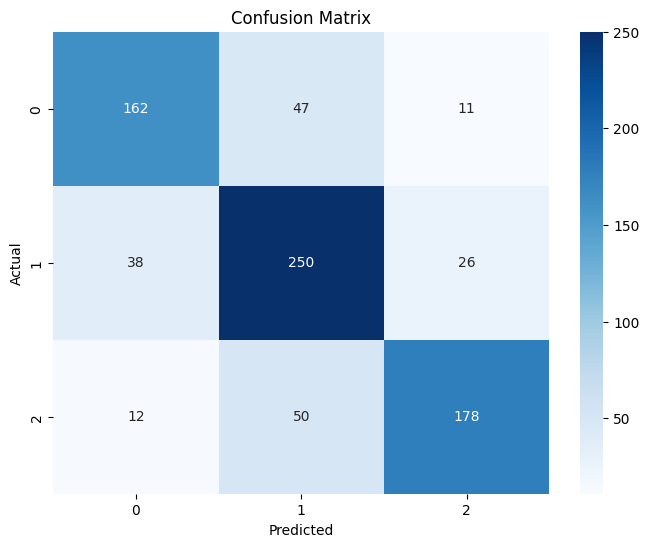

In [30]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Model 3: Multinomial Naive Bayes

Train Naive Bayes with hyperparameter tuning:

- **alpha**: Smoothing parameter (0.01 to 1.0)
- Fast training and works well with TF-IDF features
- Assumes feature independence (words in text)


In [31]:
from sklearn.naive_bayes import MultinomialNB

pipe_nb = Pipeline([
    ("tfidf", tfidf),
    ("clf", MultinomialNB())
])

param_nb = {
    "clf__alpha": [0.01, 0.1, 0.5, 1.0]
}

rs_nb = RandomizedSearchCV(
    pipe_nb,
    param_nb,
    n_iter=5,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    random_state=42
)

rs_nb.fit(X_train, y_train)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(max_df=0.9,
                                                              min_df=5,
                                                              ngram_range=(1,
                                                                           2))),
                                             ('clf', MultinomialNB())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'clf__alpha': [0.01, 0.1, 0.5, 1.0]},
                   random_state=42, scoring='f1_macro')

In [32]:
# Best parameters
rs_nb.best_params_


{'clf__alpha': 0.01}

In [33]:
# Evaluate on test set
y_pred = rs_nb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.45      0.51       220
           1       0.55      0.74      0.63       314
           2       0.69      0.55      0.61       240

    accuracy                           0.60       774
   macro avg       0.61      0.58      0.58       774
weighted avg       0.61      0.60      0.59       774



## Step 5b: Deep Learning Models

### Model 6: Bidirectional LSTM

Train a Bidirectional LSTM neural network for sequence modeling:

- **Embedding Layer**: Converts word indices to dense vectors
- **Bidirectional LSTM**: Processes text in both forward and backward directions
- **Dropout**: Prevents overfitting
- **Dense Layer**: Final classification layer

LSTM models can capture long-range dependencies and context in Khmer text better than traditional ML models.


In [34]:
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.callbacks import EarlyStopping
    
    # Tokenize text for LSTM
    max_words = 5000
    max_len = 100
    
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)
    
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

    # Labels are already numeric (0, 1, 2), no need for LabelEncoder
    y_train_lstm = y_train.values
    y_test_lstm = y_test.values
    
    # Build BiLSTM model
    model_lstm = Sequential([
        Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(32)),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    
    model_lstm.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train with early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    print("Training Bidirectional LSTM...")
    history = model_lstm.fit(
        X_train_pad, y_train_lstm,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )
    
    print("BiLSTM trained successfully")
    
except ImportError as e:
    print(f"Warning: TensorFlow not installed. Run: pip install tensorflow")
    print(f"Error: {e}")
    model_lstm = None
    tokenizer = None

Training Bidirectional LSTM...
Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 0.3958 - loss: 1.0915 - val_accuracy: 0.3613 - val_loss: 1.0949
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.4346 - loss: 1.0683 - val_accuracy: 0.4468 - val_loss: 1.0230
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.6995 - loss: 0.7134 - val_accuracy: 0.7177 - val_loss: 0.6930
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.9229 - loss: 0.2368 - val_accuracy: 0.7516 - val_loss: 0.6670
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.9519 - loss: 0.1461 - val_accuracy: 0.7516 - val_loss: 0.6301
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.9540 - loss: 0.1084 - val_accuracy: 0.7677 - val_loss: 0.6944
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.9495 - loss: 0.1284 - val_accuracy: 0.7629 - val_loss: 0.8794
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.9548 

In [35]:
try:
    import xgboost as xgb
    
    # Labels are already numeric (0, 1, 2), no need for LabelEncoder
    y_train_encoded = y_train.values
    y_test_encoded = y_test.values
    
    # Calculate scale_pos_weight for each class
    from collections import Counter
    class_counts = Counter(y_train_encoded)
    total_negative = sum([class_counts[i] for i in class_counts if i != 2])
    scale_pos_weight = total_negative / class_counts.get(2, 1) if 2 in class_counts else 1
    
    pipe_xgb = Pipeline([
        ("tfidf", tfidf),
        ("clf", xgb.XGBClassifier(
            objective='multi:softmax',
            num_class=3,
            random_state=42,
            n_jobs=-1,
            eval_metric='mlogloss'
        ))
    ])
    
    param_xgb = {
        "clf__n_estimators": [100, 200, 300, 500, 700],
        "clf__max_depth": [3, 5, 7, 10, 15, 30],
        "clf__learning_rate": [0.01, 0.1, 0.3]
    }
    
    rs_xgb = RandomizedSearchCV(
        pipe_xgb,
        param_xgb,
        n_iter=10,
        scoring="f1_macro",
        cv=3,
        n_jobs=-1,
        random_state=42
    )
    
    rs_xgb.fit(X_train, y_train_encoded)
    
    print("XGBoost trained successfully")
    
except ImportError:
    print("Warning: XGBoost not installed. Run: pip install xgboost")
    rs_xgb = None

XGBoost trained successfully


In [36]:
# best parameters
rs_xgb.best_params_


{'clf__n_estimators': 700, 'clf__max_depth': 7, 'clf__learning_rate': 0.1}

In [37]:
# Evaluate on test set
y_pred = rs_xgb.predict(X_test)
print(classification_report(y_test_encoded, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.77      0.83       220
           1       0.77      0.94      0.85       314
           2       0.89      0.76      0.82       240

    accuracy                           0.83       774
   macro avg       0.85      0.82      0.83       774
weighted avg       0.84      0.83      0.83       774



### Model 5: XGBoost

Train XGBoost - a powerful gradient boosting algorithm:

- **scale_pos_weight**: Balancing parameter for imbalanced data
- **learning_rate**: Step size for weight updates
- **max_depth**: Tree depth to control complexity
- Often achieves state-of-the-art results on structured/tabular data


In [38]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline([
    ("tfidf", tfidf),
    ("clf", RandomForestClassifier(
        class_weight=class_weight,
        random_state=42,
        n_jobs=-1
    ))
])

param_rf = {
    "clf__n_estimators": [100, 200, 300, 500, 700],
    "clf__max_depth": [10, 20, 30, 50],
    "clf__min_samples_split": [2, 5, 8, 10]
}

rs_rf = RandomizedSearchCV(
    pipe_rf,
    param_rf,
    n_iter=10,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    random_state=42
)

rs_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(max_df=0.9,
                                                              min_df=5,
                                                              ngram_range=(1,
                                                                           2))),
                                             ('clf',
                                              RandomForestClassifier(class_weight={np.int64(0): np.float64(1.174863387978142),
                                                                                   np.int64(1): np.float64(0.821656050955414),
                                                                                   np.int64(2): np.float64(1.0732113144758735)},
                                                                     n_jobs=-1,
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'clf__max_depth': [10, 20, 30, 50],
                                        'clf__min_samples_split': [2, 5, 8, 10],
                                        'clf__n_estimators': [100, 200, 300,
                                                              500, 700]},
                   random_state=42, scoring='f1_macro')

In [39]:
# best parameters
rs_rf.best_params_

{'clf__n_estimators': 100, 'clf__min_samples_split': 8, 'clf__max_depth': 50}

In [40]:
# Evaluate on test set
y_pred = rs_rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.66      0.73       220
           1       0.69      0.91      0.78       314
           2       0.90      0.67      0.77       240

    accuracy                           0.77       774
   macro avg       0.80      0.75      0.76       774
weighted avg       0.79      0.77      0.76       774



### Model 4: Random Forest

Train Random Forest classifier - an ensemble method that combines multiple decision trees:

- **n_estimators**: Number of trees in the forest
- **max_depth**: Maximum depth of trees (prevent overfitting)
- **class_weight='balanced'**: Handle class imbalance
- Robust to overfitting and captures non-linear patterns


## Step 6: Model Evaluation and Comparison

### Key Task: Analyze errors and challenges specific to Khmer sentiment classification

Evaluate all trained models on the test set using:

- **Accuracy**: Overall correct predictions
- **Precision**: Correctness of positive predictions per class
- **Recall**: Coverage of actual positives per class
- **F1-Score**: Harmonic mean of precision and recall

Compare performance across all three models to identify the best approach for Khmer sentiment analysis.


In [41]:
from sklearn.metrics import classification_report

# Update models dictionary with all trained models
models = {
    "Logistic Regression": rs_lr,
    "SVM": rs_svm,
    "Naive Bayes": rs_nb,
    "Random Forest": rs_rf
}

# Add XGBoost if available
if rs_xgb is not None:
    models["XGBoost"] = rs_xgb

# Label names for display (0: negative, 1: neutral, 2: positive)
label_names = ["negative", "neutral", "positive"]

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print(classification_report(y_test, y_pred, target_names=label_names))

# Evaluate LSTM if available
if model_lstm is not None:
    print("\nBidirectional LSTM")
    y_pred_lstm = model_lstm.predict(X_test_pad, verbose=0)
    y_pred_lstm_classes = y_pred_lstm.argmax(axis=1)
    print(classification_report(y_test, y_pred_lstm_classes, target_names=label_names))


Logistic Regression
              precision    recall  f1-score   support

    negative       0.73      0.71      0.72       220
     neutral       0.69      0.74      0.71       314
    positive       0.79      0.72      0.75       240

    accuracy                           0.73       774
   macro avg       0.73      0.73      0.73       774
weighted avg       0.73      0.73      0.73       774


SVM
              precision    recall  f1-score   support

    negative       0.76      0.74      0.75       220
     neutral       0.72      0.80      0.76       314
    positive       0.83      0.74      0.78       240

    accuracy                           0.76       774
   macro avg       0.77      0.76      0.76       774
weighted avg       0.77      0.76      0.76       774


Naive Bayes
              precision    recall  f1-score   support

    negative       0.59      0.45      0.51       220
     neutral       0.55      0.74      0.63       314
    positive       0.69      0.55   

### Confusion Matrix Analysis

Visualize confusion matrices to identify specific error patterns and misclassification issues in Khmer sentiment prediction.


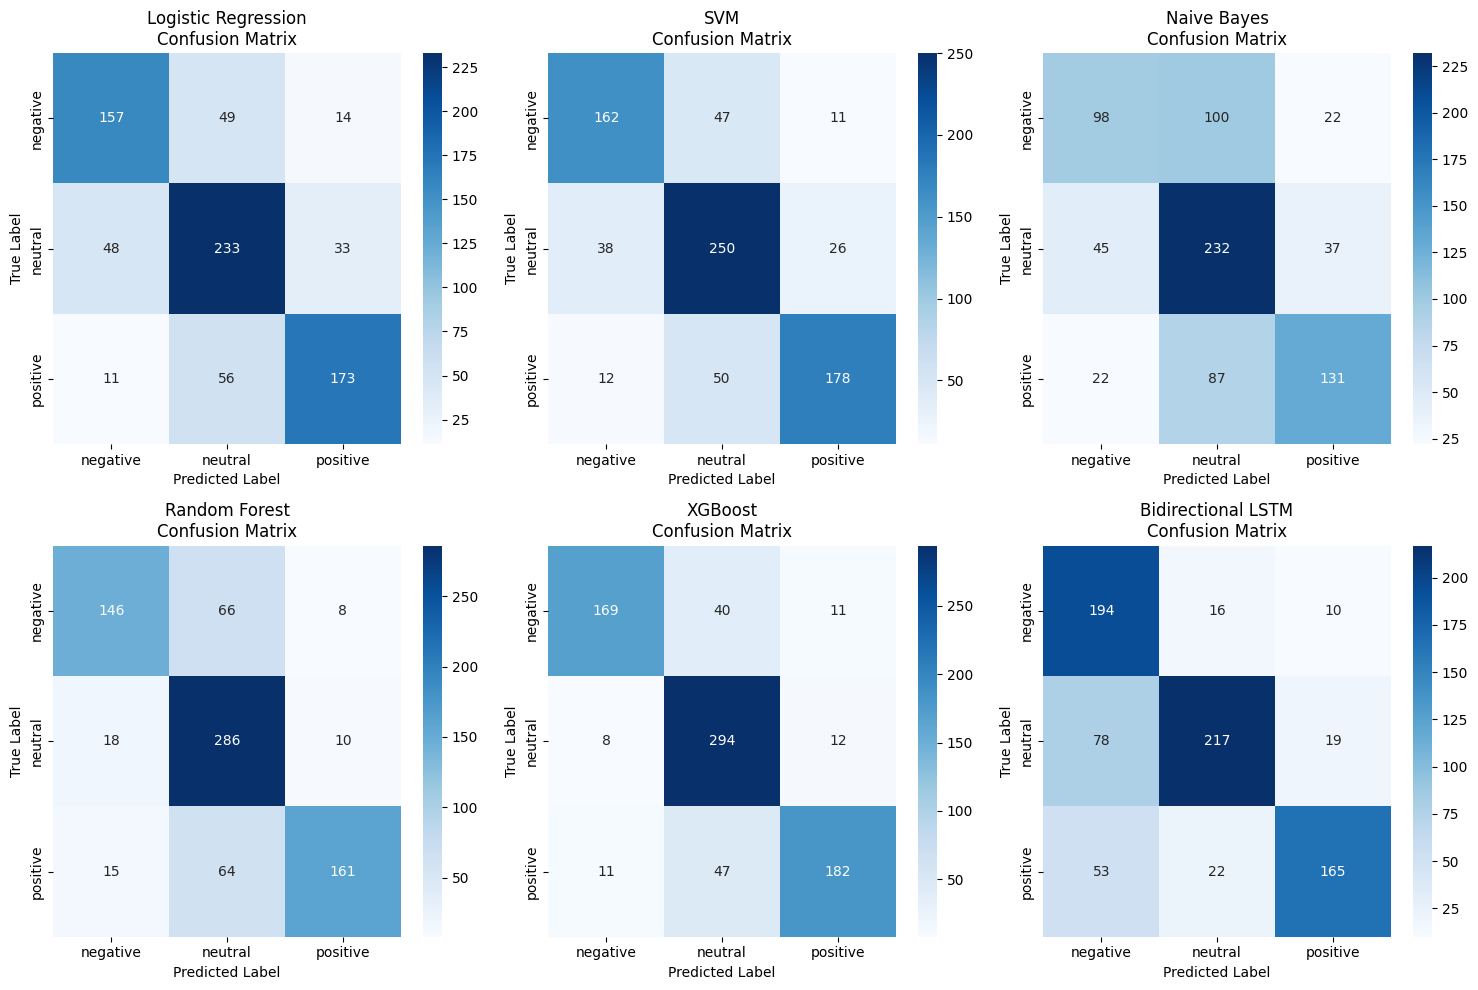

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate number of models for subplot layout
num_models = len(models) + (1 if model_lstm is not None else 0)
cols = 3
rows = (num_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten() if num_models > 1 else [axes]

idx = 0

# Label names for confusion matrix
cm_labels = ['negative', 'neutral', 'positive']

# Traditional ML models
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=cm_labels, 
                yticklabels=cm_labels,
                ax=axes[idx])
    axes[idx].set_title(f'{name}\nConfusion Matrix')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')
    idx += 1

# LSTM model
if model_lstm is not None:
    y_pred_lstm = model_lstm.predict(X_test_pad, verbose=0)
    y_pred_lstm_classes = y_pred_lstm.argmax(axis=1)
    cm = confusion_matrix(y_test, y_pred_lstm_classes)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=cm_labels, 
                yticklabels=cm_labels,
                ax=axes[idx])
    axes[idx].set_title('Bidirectional LSTM\nConfusion Matrix')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')
    idx += 1

# Hide unused subplots
for i in range(idx, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Error Analysis: Examining Misclassifications

Identify and analyze specific examples where the best model made incorrect predictions. This helps understand challenges specific to Khmer sentiment classification.


In [43]:
# Select the best performing model (based on F1-score)
best_model_name = max(models.keys(), key=lambda k: models[k].best_score_)
best_model = models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Best F1-Macro Score: {best_model.best_score_:.4f}")
print(f"Best Parameters: {best_model.best_params_}")

# Get predictions
y_pred = best_model.predict(X_test)

# Find misclassified examples
misclassified_idx = X_test.index[y_test != y_pred].tolist()

# Label mapping for display
label_names = {0: 'negative', 1: 'neutral', 2: 'positive'}

# Display sample misclassifications
print("\n" + "="*80)
print("SAMPLE MISCLASSIFICATIONS - Understanding Khmer Sentiment Challenges")
print("="*80)

for i, idx in enumerate(misclassified_idx[:10]):  # Show first 10 errors
    print(f"\nExample {i+1}:")
    print(f"Text: {df.loc[idx, 'text'][:100]}...")  # Show first 100 chars
    print(f"Cleaned: {df.loc[idx, 'text_clean'][:100]}...")
    true_label = y_test.loc[idx]
    pred_label = y_pred[list(X_test.index).index(idx)]
    print(f"True Sentiment: {label_names[true_label]} ({true_label})")
    print(f"Predicted: {label_names[pred_label]} ({pred_label})")
    print("-" * 80)

Best Model: XGBoost
Best F1-Macro Score: 0.7400
Best Parameters: {'clf__n_estimators': 700, 'clf__max_depth': 7, 'clf__learning_rate': 0.1}

SAMPLE MISCLASSIFICATIONS - Understanding Khmer Sentiment Challenges

Example 1:
Text: គ្មាន AC កង្ហារមិនបង្វិលផ្លូវរបស់យើងទេ ... យើងកំពុងបែកញើសវាចេញនៅថ្ងៃក្តៅ...
Cleaned: គ្មាន កង្ហារមិនខ្ញុំ្វិលផ្លូវរបស់យើងទេ ... យើងកំពុងបែកញើសវាចេញនៅថ្ងៃក្តៅ...
True Sentiment: negative (0)
Predicted: neutral (1)
--------------------------------------------------------------------------------

Example 2:
Text: ឱប ៤ ខេធី។ទោះបីជាម្តាយរបស់ខ្ញុំនៅស្ថានសួគ៌ក៏ដោយ ខ្ញុំដឹងថានាងញញឹមចំពោះសមិទ្ធិផលរបស់ខ្ញុំ និងមនុស្សទា...
Cleaned: ឱប ៤ ខេធី។ទោះបីជាម្តាយរបស់ខ្ញុំនៅស្ថានសួគ៌ក៏ដោយ ខ្ញុំដឹងថានាងញញឹមចំពោះសមិទ្ធិផលរបស់ខ្ញុំ និងមនុស្សទា...
True Sentiment: positive (2)
Predicted: negative (0)
--------------------------------------------------------------------------------

Example 3:
Text: ខ្ញុំសុំទោសយ៉ាងហោចណាស់វាជាថ្ងៃសុក្រ?...
Cleaned: ខ្ញុំសុំទោសយ៉ាងហោចណាស់វាជាថ្ងៃសុក្រ?...
Tr

## Step 7: Challenges and Observations in Khmer Sentiment Classification

### Challenges Specific to Khmer Text:

1. **Limited NLP Resources**:

   - Unlike English, Khmer lacks extensive pre-trained models and linguistic tools
   - No standard tokenizers or POS taggers for Khmer
   - Solution: Unicode-aware character-level and word-level features with TF-IDF

2. **Unicode Complexity**:

   - Khmer has complex Unicode structure with combining characters
   - Multiple representations of the same character
   - Solution: NFC normalization to standardize representation

3. **Informal Writing Styles**:

   - Social media uses heavy slang, abbreviations, and mixed scripts
   - Non-standard spelling variations
   - Solution: Slang mapping dictionary (needs continuous expansion)

4. **Context-Dependent Sentiment**:

   - Khmer sentiment often relies on cultural context and implied meaning
   - Sarcasm and irony are common in Khmer social media
   - Solution: N-gram features to capture some contextual information

5. **Class Imbalance**:

   - Real-world data often has unbalanced sentiment distribution
   - Solution: Class weights and stratified sampling

6. **Mixed Language Content**:
   - Khmer posts often include English words and emojis
   - Solution: Preserve both Khmer and numbers in preprocessing

### Next Steps for Improvement:

- **Deep Learning Models**: Implement LSTM or BERT-based models for better context understanding
- **Data Augmentation**: Expand training data and slang dictionary
- **Feature Engineering**: Experiment with character-level features
- **Ensemble Methods**: Combine multiple models for improved robustness


## Step 8: Model Comparison Summary

Create a comprehensive comparison table of all models to visualize performance differences.



MODEL COMPARISON - Khmer Sentiment Analysis (Traditional ML + Deep Learning)
              Model  Accuracy  F1-Macro  Precision-Macro  Recall-Macro  Best CV Score
            XGBoost    0.8333    0.8308           0.8528        0.8209         0.7400
                SVM    0.7623    0.7629           0.7708        0.7581         0.6758
      Random Forest    0.7661    0.7613           0.8009        0.7484         0.6948
 Bidirectional LSTM    0.7442    0.7450           0.7661        0.7535         0.7677
Logistic Regression    0.7274    0.7290           0.7342        0.7255         0.6752
        Naive Bayes    0.5956    0.5838           0.6124        0.5767         0.5835


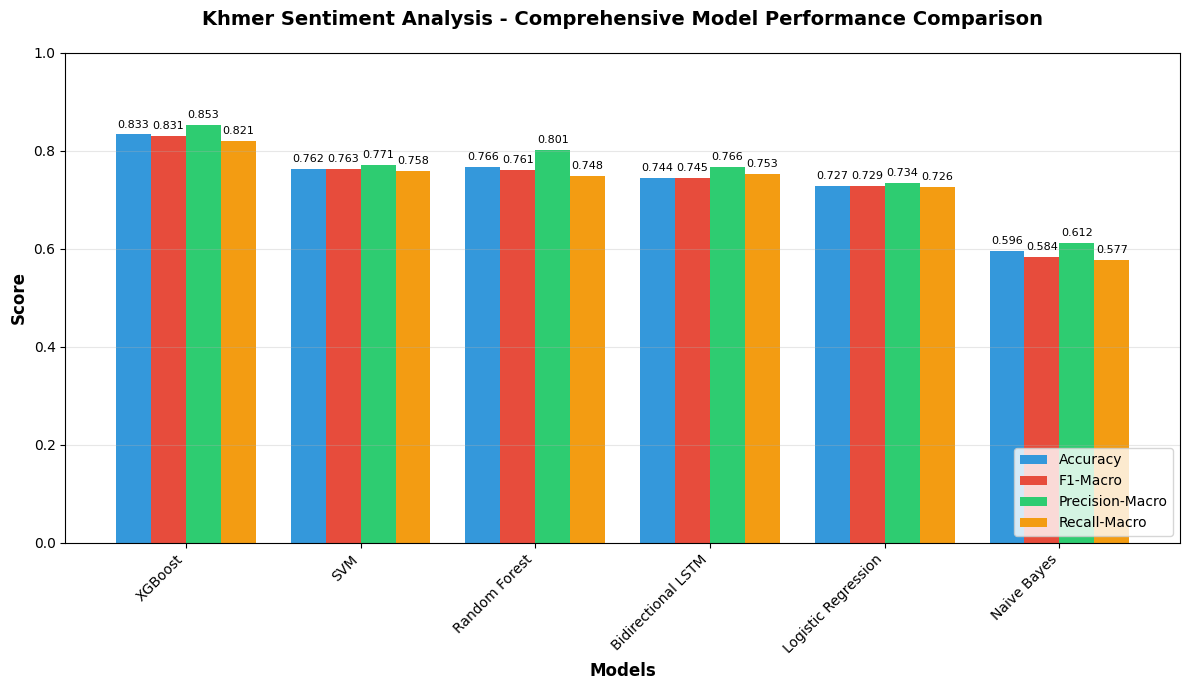


Best Model: XGBoost
   F1-Macro Score: 0.8308


In [44]:
# Create comprehensive model comparison
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

comparison_results = []

# Traditional ML models (all work with numeric labels directly)
for name, model in models.items():
    y_pred = model.predict(X_test)
    
    result = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-Macro': f1_score(y_test, y_pred, average='macro'),
        'Precision-Macro': precision_score(y_test, y_pred, average='macro'),
        'Recall-Macro': recall_score(y_test, y_pred, average='macro'),
        'Best CV Score': model.best_score_
    }
    comparison_results.append(result)

# LSTM model (also works with numeric labels directly)
if model_lstm is not None:
    y_pred_lstm = model_lstm.predict(X_test_pad, verbose=0)
    y_pred_lstm_classes = y_pred_lstm.argmax(axis=1)
    
    result = {
        'Model': 'Bidirectional LSTM',
        'Accuracy': accuracy_score(y_test, y_pred_lstm_classes),
        'F1-Macro': f1_score(y_test, y_pred_lstm_classes, average='macro'),
        'Precision-Macro': precision_score(y_test, y_pred_lstm_classes, average='macro'),
        'Recall-Macro': recall_score(y_test, y_pred_lstm_classes, average='macro'),
        'Best CV Score': max(history.history['val_accuracy']) if 'val_accuracy' in history.history else 0
    }
    comparison_results.append(result)

# Create DataFrame for easy visualization
comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.round(4)
comparison_df = comparison_df.sort_values('F1-Macro', ascending=False)

print("\n" + "="*90)
print("MODEL COMPARISON - Khmer Sentiment Analysis (Traditional ML + Deep Learning)")
print("="*90)
print(comparison_df.to_string(index=False))
print("="*90)

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 7))
x = np.arange(len(comparison_df))
width = 0.2

metrics = ['Accuracy', 'F1-Macro', 'Precision-Macro', 'Recall-Macro']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, comparison_df[metric], width, label=metric, color=colors[i])

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Khmer Sentiment Analysis - Comprehensive Model Performance Comparison', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.0)

# Add value labels on bars
for i, metric in enumerate(metrics):
    for j, value in enumerate(comparison_df[metric]):
        ax.text(j + i*width, value + 0.01, f'{value:.3f}', 
                ha='center', va='bottom', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()

# Print best model
best_model_idx = comparison_df['F1-Macro'].idxmax()
print(f"\nBest Model: {comparison_df.loc[best_model_idx, 'Model']}")
print(f"   F1-Macro Score: {comparison_df.loc[best_model_idx, 'F1-Macro']:.4f}")

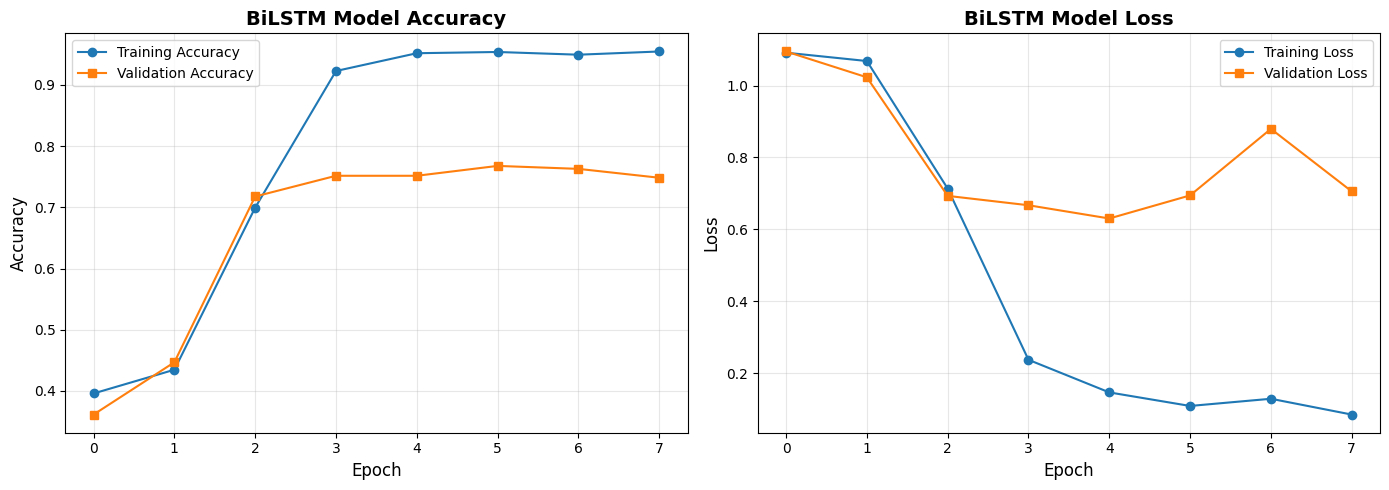


Final Training Accuracy: 0.9548
Final Validation Accuracy: 0.7484
Best Validation Accuracy: 0.7677


In [45]:
if model_lstm is not None and history is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    ax1.set_title('BiLSTM Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', marker='o')
    ax2.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    ax2.set_title('BiLSTM Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
else:
    print("LSTM model not trained. Install TensorFlow to enable deep learning models.")

In [ ]:
# Plot training/validation accuracy and loss for all models (including LSTM) in one page
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder

# Encode labels for models that require integer labels (e.g., XGBoost)
le = LabelEncoder()
le.fit(y_train)

model_names = list(models.keys())
include_lstm = model_lstm is not None and history is not None
n_models = len(model_names) + (1 if include_lstm else 0)
fig, axes = plt.subplots(2, n_models, figsize=(8 * n_models, 14), sharey='row')

for idx, model_name in enumerate(model_names):
    search_cv = models[model_name]
    estimator = search_cv.best_estimator_
    # Use integer labels for XGBoost, string labels for others
    y_train_plot = le.transform(y_train) if model_name == "XGBoost" else y_train

    train_sizes, train_scores, val_scores = learning_curve(
        estimator,
        X_train, y_train_plot,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        shuffle=True,
        random_state=42
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)

    # Accuracy subplot
    ax_acc = axes[0, idx]
    ax_acc.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Accuracy')
    ax_acc.plot(train_sizes, val_scores_mean, 's-', color='orange', label='Validation Accuracy')
    ax_acc.set_title(f'{model_name} Accuracy', fontsize=14, fontweight='bold')
    ax_acc.set_xlabel('Training Set Size', fontsize=12)
    if idx == 0:
        ax_acc.set_ylabel('Accuracy', fontsize=12)
    ax_acc.legend()
    ax_acc.grid(True, alpha=0.3)

    # Loss subplot (simulated as 1 - accuracy)
    ax_loss = axes[1, idx]
    ax_loss.plot(train_sizes, 1-train_scores_mean, 'o-', color='red', label='Training Loss')
    ax_loss.plot(train_sizes, 1-val_scores_mean, 's-', color='purple', label='Validation Loss')
    ax_loss.set_title(f'{model_name} Loss', fontsize=14, fontweight='bold')
    ax_loss.set_xlabel('Training Set Size', fontsize=12)
    if idx == 0:
        ax_loss.set_ylabel('Loss', fontsize=12)
    ax_loss.legend()
    ax_loss.grid(True, alpha=0.3)

# Add LSTM model plots in the last column if available
if include_lstm:
    idx = n_models - 1
    # Accuracy
    ax_acc_lstm = axes[0, idx]
    ax_acc_lstm.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label='Training Accuracy', marker='o')
    ax_acc_lstm.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    ax_acc_lstm.set_title('BiLSTM Accuracy', fontsize=14, fontweight='bold')
    ax_acc_lstm.set_xlabel('Epoch', fontsize=12)
    ax_acc_lstm.set_ylabel('Accuracy', fontsize=12)
    ax_acc_lstm.legend()
    ax_acc_lstm.grid(True, alpha=0.3)
    # Loss
    ax_loss_lstm = axes[1, idx]
    ax_loss_lstm.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label='Training Loss', marker='o')
    ax_loss_lstm.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label='Validation Loss', marker='s')
    ax_loss_lstm.set_title('BiLSTM Loss', fontsize=14, fontweight='bold')
    ax_loss_lstm.set_xlabel('Epoch', fontsize=12)
    ax_loss_lstm.set_ylabel('Loss', fontsize=12)
    ax_loss_lstm.legend()
    ax_loss_lstm.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

SyntaxError: unterminated string literal (detected at line 66) (583409053.py, line 66)

### LSTM Training History Visualization

Visualize the training and validation performance of the BiLSTM model across epochs.


## Step 9: Save Best Model

Save the best performing model along with necessary preprocessing objects for future use.


In [47]:
import joblib
import json
from datetime import datetime
import os

# Create models directory if it doesn't exist
os.makedirs('models/saved_models', exist_ok=True)
os.makedirs('results/reports', exist_ok=True)

# Get the best model based on F1-Macro score
best_model_idx = comparison_df['F1-Macro'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_model_f1 = comparison_df.loc[best_model_idx, 'F1-Macro']

print("="*80)
print(f"SAVING BEST MODEL: {best_model_name}")
print(f"   F1-Macro Score: {best_model_f1:.4f}")
print("="*80)

# Save based on model type
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

if best_model_name == "Bidirectional LSTM" and model_lstm is not None:
    # Save LSTM model
    model_path = f'models/saved_models/best_model_lstm_{timestamp}.keras'
    model_lstm.save(model_path)
    print(f"LSTM model saved: {model_path}")
    
    # Save tokenizer
    tokenizer_path = f'models/saved_models/tokenizer_lstm_{timestamp}.pkl'
    joblib.dump(tokenizer, tokenizer_path)
    print(f"Tokenizer saved: {tokenizer_path}")
    
    # Save label encoder
    le_path = f'models/saved_models/label_encoder_lstm_{timestamp}.pkl'
    joblib.dump(le_lstm, le_path)
    print(f"Label Encoder saved: {le_path}")
    
    # Save model metadata
    metadata = {
        'model_name': best_model_name,
        'model_type': 'deep_learning',
        'timestamp': timestamp,
        'performance': {
            'accuracy': float(comparison_df.loc[best_model_idx, 'Accuracy']),
            'f1_macro': float(comparison_df.loc[best_model_idx, 'F1-Macro']),
            'precision_macro': float(comparison_df.loc[best_model_idx, 'Precision-Macro']),
            'recall_macro': float(comparison_df.loc[best_model_idx, 'Recall-Macro'])
        },
        'hyperparameters': {
            'max_words': max_words,
            'max_len': max_len,
            'embedding_dim': 128,
            'lstm_units': 64
        },
        'files': {
            'model': model_path,
            'tokenizer': tokenizer_path,
            'label_encoder': le_path
        }
    }
    
else:
    # Save traditional ML model
    if best_model_name == "Logistic Regression":
        best_model_obj = rs_lr
    elif best_model_name == "SVM":
        best_model_obj = rs_svm
    elif best_model_name == "Naive Bayes":
        best_model_obj = rs_nb
    elif best_model_name == "Random Forest":
        best_model_obj = rs_rf
    elif best_model_name == "XGBoost":
        best_model_obj = rs_xgb
    
    # Save the model
    model_path = f'models/saved_models/best_model_{best_model_name.lower().replace(" ", "_")}_{timestamp}.pkl'
    joblib.dump(best_model_obj, model_path)
    print(f"Model saved: {model_path}")
    
    # Save TF-IDF vectorizer (if not already in the pipeline)
    # The model pipeline already includes TF-IDF, so no need to save separately
    
    # For XGBoost, save label encoder
    if best_model_name == "XGBoost":
        le_path = f'models/saved_models/label_encoder_xgb_{timestamp}.pkl'
        joblib.dump(le, le_path)
        print(f"Label Encoder saved: {le_path}")
    
    # Save model metadata
    metadata = {
        'model_name': best_model_name,
        'model_type': 'traditional_ml',
        'timestamp': timestamp,
        'performance': {
            'accuracy': float(comparison_df.loc[best_model_idx, 'Accuracy']),
            'f1_macro': float(comparison_df.loc[best_model_idx, 'F1-Macro']),
            'precision_macro': float(comparison_df.loc[best_model_idx, 'Precision-Macro']),
            'recall_macro': float(comparison_df.loc[best_model_idx, 'Recall-Macro']),
            'best_cv_score': float(comparison_df.loc[best_model_idx, 'Best CV Score'])
        },
        'hyperparameters': best_model_obj.best_params_,
        'files': {
            'model': model_path,
            'label_encoder': le_path if best_model_name == "XGBoost" else None
        }
    }

# Save metadata as JSON
metadata_path = f'models/saved_models/best_model_metadata_{timestamp}.json'
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=4, ensure_ascii=False)
print(f"Metadata saved: {metadata_path}")

print("\n" + "="*80)
print("MODEL SAVED SUCCESSFULLY")
print("="*80)

SAVING BEST MODEL: XGBoost
   F1-Macro Score: 0.8308
Model saved: models/saved_models/best_model_xgboost_20260113_180558.pkl
Label Encoder saved: models/saved_models/label_encoder_xgb_20260113_180558.pkl
Metadata saved: models/saved_models/best_model_metadata_20260113_180558.json

MODEL SAVED SUCCESSFULLY


### Save Model Comparison Report

Export the comparison results to a CSV file for documentation and future reference.


In [ ]:
# Save comparison results to CSV
report_path = f'results/reports/model_comparison_{timestamp}.csv'
comparison_df.to_csv(report_path, index=False, encoding='utf-8-sig')
print(f"Model comparison report saved: {report_path}")

# Display final summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"Best Model: {best_model_name}")
print(f"Accuracy: {comparison_df.loc[best_model_idx, 'Accuracy']:.4f}")
print(f"F1-Macro: {comparison_df.loc[best_model_idx, 'F1-Macro']:.4f}")
print(f"Precision-Macro: {comparison_df.loc[best_model_idx, 'Precision-Macro']:.4f}")
print(f"Recall-Macro: {comparison_df.loc[best_model_idx, 'Recall-Macro']:.4f}")
print("\nSaved Files:")
print(f"   - Model: models/saved_models/")
print(f"   - Report: {report_path}")
print(f"   - Metadata: {metadata_path}")
print("="*80)

✓ Model comparison report saved: results/reports/model_comparison_20260103_142751.csv

📊 FINAL SUMMARY
Best Model: SVM
Accuracy: 0.5355
F1-Macro: 0.5201
Precision-Macro: 0.5187
Recall-Macro: 0.5248

📁 Saved Files:
   - Model: models/saved_models/
   - Report: results/reports/model_comparison_20260103_142751.csv
   - Metadata: models/saved_models/best_model_metadata_20260103_142751.json


### How to Load and Use the Saved Model

Instructions for loading and using the saved model for future predictions:

**For Traditional ML Models:**

```python
import joblib

# Load the model
model = joblib.load('models/saved_models/best_model_*.pkl')

# For XGBoost, also load label encoder
# le = joblib.load('models/saved_models/label_encoder_xgb_*.pkl')

# Make predictions
predictions = model.predict(new_text_data)
```

**For LSTM Model:**

```python
import joblib
from tensorflow import keras

# Load the model
model = keras.models.load_model('models/saved_models/best_model_lstm_*.keras')

# Load tokenizer and label encoder
tokenizer = joblib.load('models/saved_models/tokenizer_lstm_*.pkl')
le = joblib.load('models/saved_models/label_encoder_lstm_*.pkl')

# Preprocess new text
sequences = tokenizer.texts_to_sequences(new_text_data)
padded = pad_sequences(sequences, maxlen=max_len, padding='post')

# Make predictions
predictions = model.predict(padded)
predicted_classes = predictions.argmax(axis=1)
predicted_labels = le.inverse_transform(predicted_classes)
```
